In [ ]:
# https://arxiv.org/abs/cond-mat/0703314
# https://arxiv.org/abs/0808.3779

# https://github.com/scipy/scipy/issues/7151
# https://apps.dtic.mil/sti/pdfs/AD1004183.pdf
# https://www.codeproject.com/Articles/21282/Compute-Permanent-of-a-Matrix-with-Ryser-s-Algorit

# https://rosettacode.org/wiki/Determinant_and_permanent
# https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible

# https://stackoverflow.com/questions/38738835/generating-gray-codes
# https://qiita.com/b1ueskydragon/items/75cfee42541ea723080c

# https://qiita.com/phdax/items/3064de264c7933bab2f5
# https://web.archive.org/web/20190108235115/https://www.hackersdelight.org/hdcodetxt/pop.c.txt
# http://graphics.stanford.edu/~seander/bithacks.html#CountBitsSetParallel
# https://stackoverflow.com/questions/9829578/fast-way-of-counting-non-zero-bits-in-positive-integer

# https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time

In [3]:
# https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [4]:
@jit(nopython=True)
def calc_rsks(L):
    rs = np.arange(1,L+1) ## from 1 to L
    ks = np.linspace(np.pi/(L+1.0),L*np.pi/(L+1.0),L)
    return rs,ks

@jit(nopython=True)
def calc_eks(J,ks):
    return -2.0*J*np.cos(ks)

@jit(nopython=True)
def calc_xkrs(L,ks,rs):
    return np.sqrt(2.0/(L+1.0))*np.sin(np.outer(ks,rs))

@jit(nopython=True)
def calc_ys(t,eks,xkrs):
    xc = (1.0+0.0j)*xkrs # for numba
    expeks = np.diag(np.exp(1j*t*eks))
    return xc @ expeks @ xc

# @jit(nopython=True)
# def calc_fs(ys,system):
#     diag = (1.0+0.0j)*np.diag(system)
#     return ys @ diag @ ys.T.conjugate()

@jit(nopython=True)
def calc_fs_cdw(ys,system,period=1):
    diag = (1.0+0.0j)*np.diag(system)
    ycuts = np.copy(ys[::period,:]) ## avoid NumbaPerformanceWarning to make contiguous arrays by deep copy
#    ycuts = ys[::period,:]
    return ycuts @ diag @ ycuts.T.conjugate()

@jit(nopython=True)
def calc_z(L,system,t,eks,xkrs,period=1):
    ys = calc_ys(t,eks,xkrs)
#    fs = calc_fs(ys,system)
    fs = calc_fs_cdw(ys,system,period)
    dlt = np.eye(fs.shape[0],dtype=np.complex128)
    return np.vstack( (np.hstack((fs,dlt-fs)), np.hstack((dlt-fs,fs))) )

@jit(nopython=True)
def get_dat(L,system,J,ts,period=1):
    rs, ks = calc_rsks(L)
    eks = calc_eks(J,ks)
    xkrs = calc_xkrs(L,ks,rs)
    data = np.zeros((len(ts),2),dtype=np.float64)
    for i,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period)
        data[i] = np.array([t,-np.log(perm_bbfg(matz).real)])
    return data

In [5]:
@jit(nopython=True)
def get_dat_2(L,system,J,ts,Nsmp,rnd,period=1):
    rs, ks = calc_rsks(L)
    eks = calc_eks(J,ks)
    xkrs = calc_xkrs(L,ks,rs)
    data = np.zeros((len(ts),2),dtype=np.float64)
    #
    #seed = 12345
    #rng = np.random.default_rng(seed)
    #Nsmp = 2**10
    data2 = np.zeros((len(ts),2),dtype=np.float64)
    data2err1 = np.zeros((len(ts),2),dtype=np.float64)
    data2err2 = np.zeros((len(ts),2),dtype=np.float64)
    #
    for i,t in enumerate(ts):
        matz = calc_z(L,system,t,eks,xkrs,period)
        #data[i] = np.array([t,-np.log(perm_bbfg(matz).real)])
        #
        lenmatz = matz.shape[0]
        bounds = np.zeros(Nsmp,dtype=np.float64)
        for step in range(Nsmp):
            #rnd = np.pi * rng.uniform(-1,1,lenmatz)
            vec = np.cos(rnd[step]) + 1j * np.sin(rnd[step])
            #bounds[step] = (np.sum(np.abs(matz.dot(vec)))/lenmatz)**lenmatz
            #bounds[step] = np.prod(np.abs(matz.dot(vec)))
            bounds[step] = np.prod(vec.conjugate()*matz.dot(vec)).real
        #data2[i] = np.array([t,-np.log(np.average(bounds))])
        #data2[i] = np.array([t,-np.log(np.sum(bounds)/len(bounds))])
        ave = np.sum(bounds)/len(bounds)
        var = np.sum((bounds-ave)**2)/len(bounds)
        err = np.sqrt(var/len(bounds))
        data2[i] = np.array([t,-np.log(ave)])
        data2err1[i] = np.array([t,-np.log(ave+err)])
        data2err2[i] = np.array([t,-np.log(np.abs(ave-err))])
        #
    return data, data2, data2err1, data2err2

In [6]:
# ## Mott insulator initial

# period = 1
# J = 1.0
# ts = np.linspace(0,20,201)
# #Ls = [4,6,8,10]
# Ls = [8,16,24,32]

# seed = 12345
# rng = np.random.default_rng(seed)
# #Nsmp = 2**14
# Nsmp = 2**16

# datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# datas2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# datas2err1 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# datas2err2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# for i,L in enumerate(Ls):
#     start = time.time()
#     #
#     rnd = np.zeros((Nsmp,2*L),dtype=np.float64)
#     for step in range(Nsmp):
#         rnd[step] = np.pi * rng.uniform(-1,1,2*L)
#     #
#     system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
# #    datas[i] = get_dat(L,system,J,ts,period)
#     datas[i], datas2[i], datas2err1[i], datas2err2[i] = get_dat_2(L,system,J,ts,Nsmp,rnd,period)
#     end = time.time()
#     print("L,calctime:",L,end-start)
    
# cmap = plt.get_cmap("tab20")
# plt.xlim(0,20)
# #plt.ylim(0,6)
# plt.grid()
# for i,L in enumerate(Ls):
#     plt.fill_between(datas2[i,:,0],datas2err1[i,:,1],datas2err2[i,:,1],fc=cmap(2*i+1),ec=cmap(2*i+0))
#     #plt.plot(datas[i,:,0],datas[i,:,1],color="black")
# plt.show()

In [7]:
# ## CDW 010101... initial

# period = 2
# J = 1.0
# #ts = np.linspace(0,20,201)
# ts = np.linspace(0,40,201)
# #Ls = [4,6,8,10,12,14,16,18,20]
# #Ls = [8,16,24,32,40,48]
# Ls = [16,32,48,64]

# seed = 12345
# rng = np.random.default_rng(seed)
# #Nsmp = 2**14
# Nsmp = 2**16

# datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# datas2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# datas2err1 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# datas2err2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
# for i,L in enumerate(Ls):
#     start = time.time()
#     #
#     rnd = np.zeros((Nsmp,L),dtype=np.float64)
#     for step in range(Nsmp):
#         rnd[step] = np.pi * rng.uniform(-1,1,L)
#     #
#     system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
# #    datas[i] = get_dat(L,system,J,ts,period)
#     datas[i], datas2[i], datas2err1[i], datas2err2[i] = get_dat_2(L,system,J,ts,Nsmp,rnd,period)
#     end = time.time()
#     print("L,calctime:",L,end-start)
    
# cmap = plt.get_cmap("tab20")
# plt.xlim(0,40)
# #plt.ylim(0,7)
# plt.grid()
# for i,L in enumerate(Ls):
#     plt.fill_between(datas2[i,:,0],datas2err1[i,:,1],datas2err2[i,:,1],fc=cmap(2*i+1),ec=cmap(2*i+0))
#     #plt.plot(datas[i,:,0],datas[i,:,1],color="black")
# plt.show()

L,calctime: 16 8.496970176696777


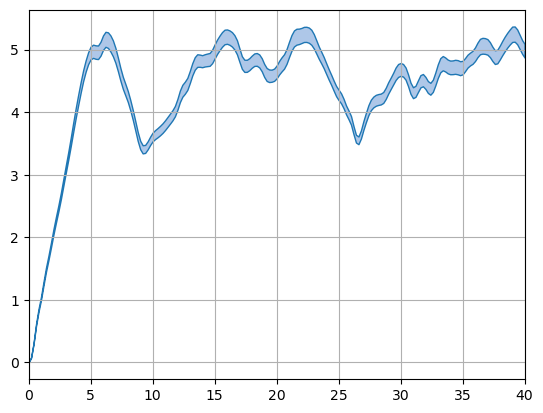

In [8]:
## CDW 010101... initial

period = 2
J = 1.0
#ts = np.linspace(0,20,201)
ts = np.linspace(0,40,201)
#Ls = [4,6,8,10,12,14,16,18,20]
#Ls = [8,16,24,32,40,48]
#Ls = [16,32,48,64]
#Ls = [64]
Ls = [16]

seed = 12345
rng = np.random.default_rng(seed)
Nsmp = 2**10
#Nsmp = 2**14
#Nsmp = 2**16
#Nsmp = 2**18

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2err1 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2err2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    #
    rnd = np.zeros((Nsmp,L),dtype=np.float64)
    for step in range(Nsmp):
        rnd[step] = np.pi * rng.uniform(-1,1,L)
    #
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
#    datas[i] = get_dat(L,system,J,ts,period)
    datas[i], datas2[i], datas2err1[i], datas2err2[i] = get_dat_2(L,system,J,ts,Nsmp,rnd,period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,40)
#plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.fill_between(datas2[i,:,0],datas2err1[i,:,1],datas2err2[i,:,1],fc=cmap(2*i+1),ec=cmap(2*i+0))
    #plt.plot(datas[i,:,0],datas[i,:,1],color="black")
plt.show()

L,calctime: 48 8.151471138000488


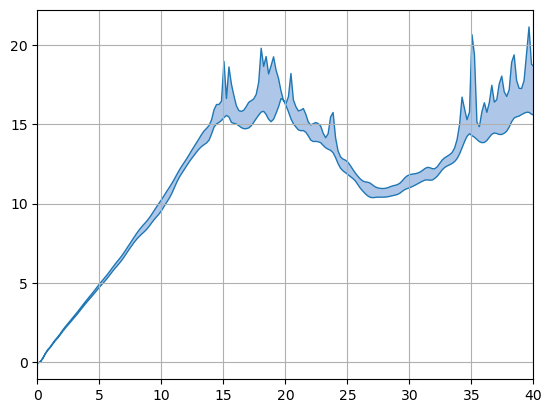

In [9]:
## CDW 010101... initial

period = 2
J = 1.0
#ts = np.linspace(0,20,201)
ts = np.linspace(0,40,201)
#Ls = [4,6,8,10,12,14,16,18,20]
#Ls = [8,16,24,32,40,48]
#Ls = [16,32,48,64]
Ls = [48]

seed = 12345
rng = np.random.default_rng(seed)
Nsmp = 2**10
#Nsmp = 2**14
#Nsmp = 2**16
#Nsmp = 2**18

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2err1 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2err2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    #
    rnd = np.zeros((Nsmp,L),dtype=np.float64)
    for step in range(Nsmp):
        rnd[step] = np.pi * rng.uniform(-1,1,L)
    #
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
#    datas[i] = get_dat(L,system,J,ts,period)
    datas[i], datas2[i], datas2err1[i], datas2err2[i] = get_dat_2(L,system,J,ts,Nsmp,rnd,period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,40)
#plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.fill_between(datas2[i,:,0],datas2err1[i,:,1],datas2err2[i,:,1],fc=cmap(2*i+1),ec=cmap(2*i+0))
    #plt.plot(datas[i,:,0],datas[i,:,1],color="black")
plt.show()

L,calctime: 64 159.75024580955505


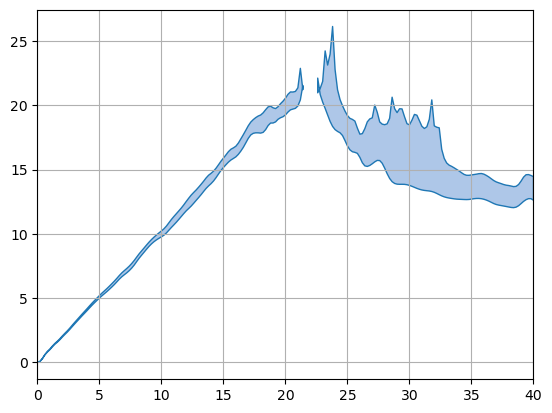

In [10]:
## CDW 010101... initial

period = 2
J = 1.0
#ts = np.linspace(0,20,201)
ts = np.linspace(0,40,201)
#Ls = [4,6,8,10,12,14,16,18,20]
#Ls = [8,16,24,32,40,48]
#Ls = [16,32,48,64]
Ls = [64]

seed = 12345
rng = np.random.default_rng(seed)
Nsmp = 2**10
#Nsmp = 2**14
#Nsmp = 2**16
#Nsmp = 2**18

datas = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2err1 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
datas2err2 = np.zeros((len(Ls),len(ts),2),dtype=np.float64)
for i,L in enumerate(Ls):
    start = time.time()
    #
    rnd = np.zeros((Nsmp,L),dtype=np.float64)
    for step in range(Nsmp):
        rnd[step] = np.pi * rng.uniform(-1,1,L)
    #
    system = np.array([1.0 if i<L//2 else 0.0 for i in range(L)])
#    datas[i] = get_dat(L,system,J,ts,period)
    datas[i], datas2[i], datas2err1[i], datas2err2[i] = get_dat_2(L,system,J,ts,Nsmp,rnd,period)
    end = time.time()
    print("L,calctime:",L,end-start)
    
cmap = plt.get_cmap("tab20")
plt.xlim(0,40)
#plt.ylim(0,7)
plt.grid()
for i,L in enumerate(Ls):
    plt.fill_between(datas2[i,:,0],datas2err1[i,:,1],datas2err2[i,:,1],fc=cmap(2*i+1),ec=cmap(2*i+0))
    #plt.plot(datas[i,:,0],datas[i,:,1],color="black")
plt.show()